In [12]:
import sys
sys.path.append("../src") 

In [13]:
import os
import pretty_midi
import pypianoroll
from lookup_tables import NOTE_TO_OFFSET
from roman_to_symbol import reset_chord_basic, to_chromagram

octave_melody = 5
root_heigest_note = 53


# voicing
def voicing(chord):
    '''
    customized function for voicing
    '''
    chord = omit(chord)
    return chord


def omit(chord):
    if chord['chord_type'] in [9, 11, 13]:
        comp_vec = chord['comp_vec']
        comp_vec[4] = None  # omit 5
        return reset_chord_basic(chord, comp_vec)
    else:
        return chord


# pianoroll
def get_key_offset(key):
    return NOTE_TO_OFFSET[key]


def wrapping_melody(melody_events, beats_sec):
    melody_track = pretty_midi.Instrument(program=0)
    init_note = octave_melody * 12

    for note in melody_events:
        if note is None:
            continue
        note_number = note['pitch'] + init_note

        # event_on/off
        start = note['event_on'] * beats_sec
        end = note['event_off'] * beats_sec

        note = pretty_midi.Note(velocity=100, pitch=int(note_number), start=start, end=end)
        melody_track.notes.append(note)
    return melody_track


def wrapping_chord(chord_events, beats_sec, to_chroma=False):
    chord_symbols = []
    chord_track = pretty_midi.Instrument(program=0)

    init_chord = (root_heigest_note // 12) * 12
    for chord in chord_events:
        if chord is None:
            continue
        # voicing
        chord = voicing(chord)

        # compress to chormagram
        comp = to_chromagram(chord['composition']) if to_chroma else chord['composition']

        # shift to lowest root location (from 0)
        re_arr = chord['bass'] // 12
        comp = comp - re_arr * 12
        bass = chord['bass'] - re_arr * 12

        # event_on/off
        start = chord['event_on'] * beats_sec
        end = chord['event_off'] * beats_sec

        # determine the initial location
        loc = init_chord + bass
        init_chord_ = (init_chord - 12) if loc > root_heigest_note else init_chord

        symbol = chord['symbol']
        chord_symbols.append(pretty_midi.Lyric(symbol, start))

        for note in comp:
            note_number = note + init_chord_
            note = pretty_midi.Note(velocity=100, pitch=int(note_number), start=start, end=end)
            chord_track.notes.append(note)

    return chord_track, chord_symbols


def proc_to_midi(
        melody_events,
        chord_events,
        key='C',
        to_chroma=False,
        bpm=120,
        beats_in_measure=4,
        save_path='./',
        name='test'):

    bpm = float(bpm)
    if bpm == 0.0:
        bpm = 120

    beats_in_measure = int(beats_in_measure)
    lead_sheet = pretty_midi.PrettyMIDI(initial_tempo=bpm)
    beats_sec = 60.0 / bpm

    chord_track, chord_symbols = wrapping_chord(chord_events, beats_sec, to_chroma=to_chroma)
    melody_track = wrapping_melody(melody_events, beats_sec)
    ts = pretty_midi.TimeSignature(beats_in_measure, 4, 0)
    ks = pretty_midi.KeySignature(get_key_offset(key), 0)

    lead_sheet.time_signature_changes.append(ts)
    lead_sheet.key_signature_changes.append(ks)

    lead_sheet.instruments.append(melody_track)
    lead_sheet.instruments.append(chord_track)
    lead_sheet.lyrics = chord_symbols

    if not os.path.exists(save_path):
        os.makedirs(save_path)
    filename = os.path.join(save_path, name+'.mid')
    lead_sheet.write(filename)
    return filename


def proc_event_to_midi(raw_symbol, save_path='./', name='test'):
    midi = proc_to_midi(
        raw_symbol['tracks']['melody'],
        raw_symbol['tracks']['chord'],
        key=raw_symbol['metadata']['key'],
        bpm=raw_symbol['metadata']['BPM'],
        beats_in_measure=raw_symbol['metadata']['beats_in_measure'],
        save_path=save_path,
        name=name)
    return midi


def proc_midi_to_pianoroll(filename, beats_in_measure):
    piano_roll = pypianoroll.parse(filename)
    piano_roll.downbeat[0::piano_roll.beat_resolution*beats_in_measure] = True
    return piano_roll


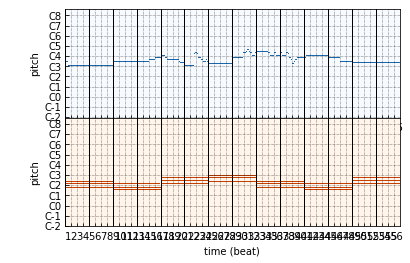

In [14]:
%matplotlib inline
from tab_parser import proc_xml
from roman_to_symbol import proc_roman_to_symbol
import matplotlib.pyplot as plt

file_path = '../datasets/xml/x/xilent/disconnect/instrumental.xml'
raw_roman = proc_xml(file_path)
filename = 'test.mid'

# to event symbol
raw_symbol = proc_roman_to_symbol(raw_roman)

# to midi
beats_in_measure = int(raw_symbol['metadata']['beats_in_measure'])
proc_event_to_midi(raw_symbol)

# to pianoroll
pianoroll = proc_midi_to_pianoroll(filename, beats_in_measure)
pianoroll.plot()
plt.savefig('test.png', dpi=500)
plt.show()
plt.close()



In [4]:
# '../datasets/xml/m/mus/love-live---angelic-angel/pre-chorus.xml'